# Imports

In [1]:
from ase import Atoms

In [2]:
from ase.build import bulk

In [3]:
from ase.calculators.morse import MorsePotential

In [4]:
from pyiron_contrib.tinybase.task import FunctionTask, SeriesTask

/home/poul/pyiron/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [5]:
from pyiron_contrib.tinybase.ase import AseStaticTask, AseMDTask, AseMinimizeTask

In [6]:
import numpy as np

In [7]:
from pyiron_contrib.tinybase.murn import MurnaghanTask

In [8]:
from pyiron_contrib.tinybase.executor import FuturesSubmitter, Submitter

In [9]:
from concurrent.futures import ThreadPoolExecutor

In [10]:
from concurrent.futures import ProcessPoolExecutor

In [11]:
make_process = lambda n: FuturesSubmitter(ProcessPoolExecutor(max_workers=n))

In [12]:
process = make_process(4)
thread = FuturesSubmitter(ThreadPoolExecutor(max_workers=4))

In [13]:
import logging
logging.getLogger().setLevel(20)

# Simple ASE Static Calculation

In [14]:
a = AseStaticTask()

In [15]:
a.input.structure = bulk("Fe")

In [16]:
a.input.calculator = MorsePotential()

In [17]:
ret, output = a.execute(); ret, output

(ReturnStatus(Code.DONE, None),
 EnergyPotOutput(energy_pot=-0.00013307075712109978))

# ASE MD

In [18]:
md = AseMDTask(capture_exceptions=False)

In [19]:
md.input.structure = bulk("Fe", a=1.2, cubic=True).repeat(3)
md.input.calculator = MorsePotential()

In [20]:
md.input.steps = 100
md.input.timestep = 3.0
md.input.temperature = 600.0
md.input.output_steps = 20

In [21]:
%%time
status, output = md.execute()

CPU times: user 49.1 s, sys: 1min 36s, total: 2min 25s
Wall time: 16.3 s


In [22]:
output.pot_energies

array([-303.20813268, -303.20813268, -298.86792333, -300.15096402,
       -300.7462843 , -300.16608615, -300.56006011, -300.59147484,
       -299.96928271, -300.51674144, -299.51395339, -301.08170514,
       -299.82074548, -299.6503962 , -300.20371318, -299.40176248,
       -300.27585337, -299.45772029, -300.95343737, -299.51643985,
       -300.44682088, -300.55408998])

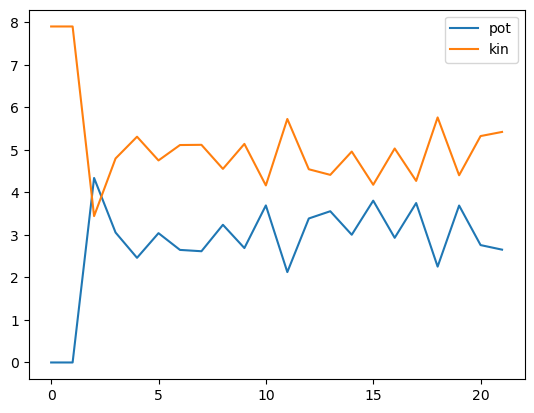

In [23]:
output.plot_energies()

In [24]:
output.animate_structures()

NGLWidget(max_frame=21)

# ASE Minimize

In [25]:
from pyiron_atomistics import ase_to_pyiron

In [26]:
mi = AseMinimizeTask()

In [27]:
dimer = Atoms(symbols=['Fe', 'Fe'], positions=[[0,0,0], [0,0, 1.2]], cell=[10,10,10])

In [28]:
mi.input.structure = dimer
mi.input.calculator = MorsePotential(rcut1=6,rcut2=10)

In [29]:
ase_to_pyiron(mi.input.structure).plot3d()

NGLWidget()

In [30]:
mi.input.max_steps = 100
mi.input.output_steps = 1
mi.input.ionic_force_tolerance = 1e-6

In [31]:
mi.input.lbfgs()

In [32]:
_, output = mi.execute()

       Step     Time          Energy         fmax
LBFGS:    0 18:22:26       -0.511670        2.5257
LBFGS:    1 18:22:26       -0.713127        2.9848
LBFGS:    2 18:22:26       -0.082483        0.4842
LBFGS:    3 18:22:26       -0.052236        0.3092
LBFGS:    4 18:22:26       -0.023154        0.1381
LBFGS:    5 18:22:26       -0.011968        0.0716
LBFGS:    6 18:22:26       -0.005874        0.0352
LBFGS:    7 18:22:26       -0.002950        0.0177
LBFGS:    8 18:22:26       -0.001470        0.0088
LBFGS:    9 18:22:26       -0.000735        0.0044
LBFGS:   10 18:22:26       -0.000368        0.0022
LBFGS:   11 18:22:26       -0.000184        0.0011
LBFGS:   12 18:22:26       -0.000092        0.0006
LBFGS:   13 18:22:26       -0.000046        0.0003
LBFGS:   14 18:22:26       -0.000023        0.0001
LBFGS:   15 18:22:26       -0.000011        0.0001
LBFGS:   16 18:22:26       -0.000006        0.0000
LBFGS:   17 18:22:26       -0.000003        0.0000
LBFGS:   18 18:22:26       -0.00

In [33]:
output.static_output()

StaticOutput(energy_kin=0.0, energy_pot=-8.972451867356014e-08)

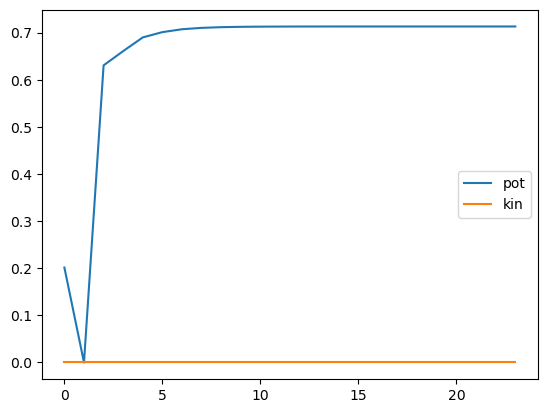

In [34]:
output.plot_energies()

In [35]:
abs(output.forces[-1]).max()

5.383470999656264e-07

In [36]:
output.animate_structures()

NGLWidget(max_frame=23)

# Murnaghan

## Basic

In [37]:
m = MurnaghanTask(capture_exceptions=False)

In [38]:
m.input.task = AseStaticTask(capture_exceptions=False)
m.input.task.input.calculator = MorsePotential()
m.input.structure = bulk("Fe", a=1.2)

In [39]:
m.input.task.input

AseStaticInput(structure=Sentinel(USERINPUT), calculator=<ase.calculators.morse.MorsePotential object at 0x7fbe4ef83cd0>)

In [40]:
m.input.set_strain_range(.5, 15)

In [41]:
m.input.strains

array([0.79370053, 0.82982653, 0.86305437, 0.89390354, 0.92275884,
       0.94991425, 0.97559996, 1.        , 1.02326411, 1.04551592,
       1.06685884, 1.08738037, 1.10715524, 1.12624788, 1.14471424])

In [42]:
_, output = m.execute()

In [43]:
output

MurnaghanOutput(base_structure=Atoms(symbols='Fe', pbc=True, cell=[[-0.6, 0.6, 0.6], [0.6, -0.6, 0.6], [0.6, 0.6, -0.6]]), volumes=array([0.432     , 0.49371429, 0.55542857, 0.61714286, 0.67885714,
       0.74057143, 0.80228571, 0.864     , 0.92571429, 0.98742857,
       1.04914286, 1.11085714, 1.17257143, 1.23428571, 1.296     ]), energies=array([ 4.78924238, -2.02281605, -5.08315968, -6.30258662, -6.60273036,
       -6.44718724, -6.07592945, -5.61496542, -5.13100331, -4.65872214,
       -4.21510997, -3.8073844 , -3.43743364, -3.10432631, -2.80567942]))

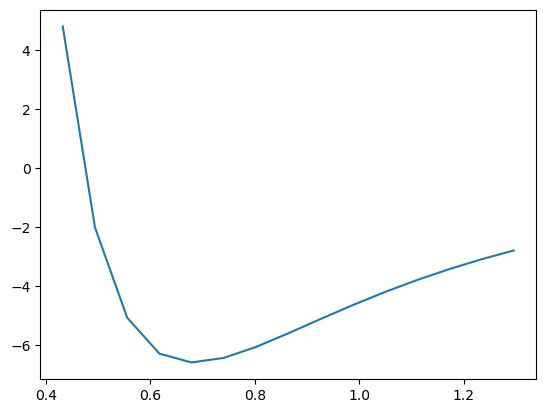

In [44]:
output.plot()

In [45]:
output.equilibrium_volume

0.6788605670604869

In [46]:
output.get_structure().get_volume()

0.6788605670604871

In [47]:
output.get_structure()

Atoms(symbols='Fe', pbc=True, cell=[[-0.553656237540387, 0.553656237540387, 0.553656237540387], [0.553656237540387, -0.553656237540387, 0.553656237540387], [0.553656237540387, 0.553656237540387, -0.553656237540387]])

## With an Executor

In [48]:
m = MurnaghanTask()

In [49]:
m.input.task = AseStaticTask()
m.input.task.input.calculator = MorsePotential()
m.input.structure = bulk("Fe", a=1.2)

In [50]:
m.input.task.input

AseStaticInput(structure=Sentinel(USERINPUT), calculator=<ase.calculators.morse.MorsePotential object at 0x7fbe4efe7810>)

In [51]:
m.input.set_strain_range(.6, 250)

In [52]:
%%time
exe = process.submit([m])
exe.run()
exe.wait()

CPU times: user 282 ms, sys: 310 ms, total: 592 ms
Wall time: 4.82 s
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33       -1.343424        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33        2.280069        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33        0.267656        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33        4.789242        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33       -2.629060        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33       -3.649939        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33       -4.454841        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33       -5.083160        0.0000
       Step     Time          Energy         fmax
LBFGS:    0 18:22:33       -5.566847        0.0000
       Step     Time  

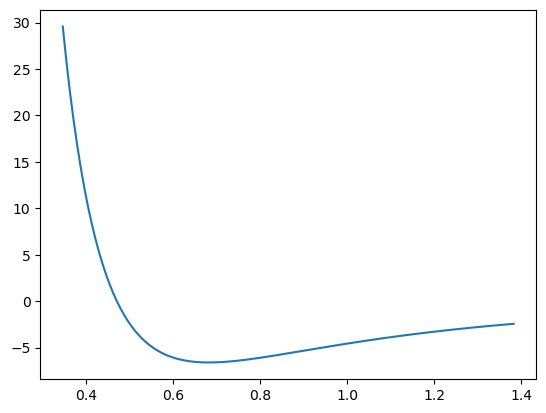

In [53]:
exe.output[0].plot()

# Combine Minimize and Murnaghan

In [54]:
m = MurnaghanTask(capture_exceptions=False)

In [55]:
mint = AseMinimizeTask(capture_exceptions=False)
mint.input.calculator = MorsePotential()
mint.input.max_steps = 100
mint.input.output_steps = 10
mint.input.ionic_force_tolerance = 1e-6
mint.input.lbfgs()

In [56]:
from operator import methodcaller
# ser = mint.then(lambda output: output.static_output())
# same as above, but can be pickled, where as lambda cannot
ser = mint.then(methodcaller('static_output'))

In [57]:
ser._capture_exceptions = False

In [58]:
# ser.execute()

In [59]:
m.input.task = ser
m.input.structure = bulk("Fe", a=1.2)

In [60]:
m.input.set_strain_range(.5, 50)

In [61]:
%%time
exe = process.submit([m])
exe.run()
exe.wait()
output = exe.output[0]
ret = exe.status[0]

CPU times: user 310 ms, sys: 327 ms, total: 638 ms
Wall time: 1.36 s


In [62]:
exe.status

[ReturnStatus(Code.DONE, None)]

In [63]:
exe.output

[MurnaghanOutput(base_structure=Atoms(symbols='Fe', pbc=True, cell=[[-0.6, 0.6, 0.6], [0.6, -0.6, 0.6], [0.6, 0.6, -0.6]]), volumes=array([0.432     , 0.44963265, 0.46726531, 0.48489796, 0.50253061,
        0.52016327, 0.53779592, 0.55542857, 0.57306122, 0.59069388,
        0.60832653, 0.62595918, 0.64359184, 0.66122449, 0.67885714,
        0.6964898 , 0.71412245, 0.7317551 , 0.74938776, 0.76702041,
        0.78465306, 0.80228571, 0.81991837, 0.83755102, 0.85518367,
        0.87281633, 0.89044898, 0.90808163, 0.92571429, 0.94334694,
        0.96097959, 0.97861224, 0.9962449 , 1.01387755, 1.0315102 ,
        1.04914286, 1.06677551, 1.08440816, 1.10204082, 1.11967347,
        1.13730612, 1.15493878, 1.17257143, 1.19020408, 1.20783673,
        1.22546939, 1.24310204, 1.26073469, 1.27836735, 1.296     ]), energies=array([ 4.78924238,  2.28006854,  0.26765599, -1.34342385, -2.62905986,
        -3.64993906, -4.4548411 , -5.08315968, -5.56684658, -5.93192168,
        -6.19965019, -6.38746798,

In [64]:
output.energies[:10]

array([ 4.78924238,  2.28006854,  0.26765599, -1.34342385, -2.62905986,
       -3.64993906, -4.4548411 , -5.08315968, -5.56684658, -5.93192168])

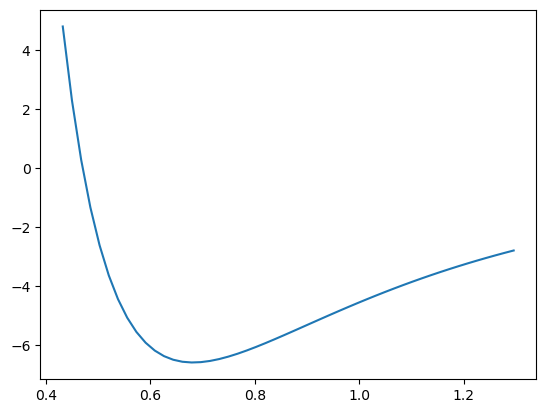

In [65]:
output.plot()

# Combine MD and Murnaghan

Obviously the one would need to increase sampling size to obtain reasonable values.

In [66]:
m = MurnaghanTask()

In [67]:
md = AseMDTask()
md.input.calculator = MorsePotential()
md.input.steps = 100
md.input.output_steps = 100
md.input.temperature = 100
md.input.timestep = 3

In [68]:
#m.input.task = md.then(lambda output: output.static_output(how=output.Mean(0.25, 1.0)))
# Same problem with pickling as above
from pyiron_contrib.tinybase.container import MDOutput
m.input.task = md.then(methodcaller('static_output', how=MDOutput.Mean(start=0.25, stop=1.0)))

In [69]:
m.input.structure = bulk("Fe", cubic=True, crystalstructure='fcc', a=1.385)

In [70]:
m.input.set_strain_range(.05, 5)

In [71]:
%%time
exe = make_process(5).submit([m])
exe.run()

exe.wait()
output = exe.output[0]
ret = exe.status[0]

CPU times: user 369 ms, sys: 292 ms, total: 661 ms
Wall time: 2min 4s


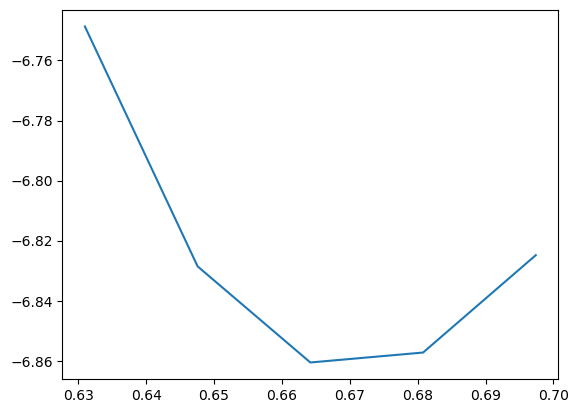

In [72]:
output.plot()

In [73]:
output

MurnaghanOutput(base_structure=Atoms(symbols='Fe4', pbc=True, cell=[1.385, 1.385, 1.385]), volumes=array([2.52390454, 2.59032308, 2.65674163, 2.72316017, 2.78957871]), energies=array([-26.99473018, -27.31430624, -27.44231513, -27.42907923,
       -27.29935109]))

In [74]:
output.equilibrium_volume

2.656743103964501

## Thermal Expansion

In [75]:
from copy import deepcopy

In [76]:
import matplotlib.pyplot as plt

In [77]:
Ts = np.linspace(50, 450, 5)
ms = []
for T in Ts:
    ms.append(deepcopy(m))
    ms[-1].input.temperature = T

In [78]:
Ts

array([ 50., 150., 250., 350., 450.])

In [79]:
exe = make_process(8).submit(ms)
exe.run()
exe.wait()

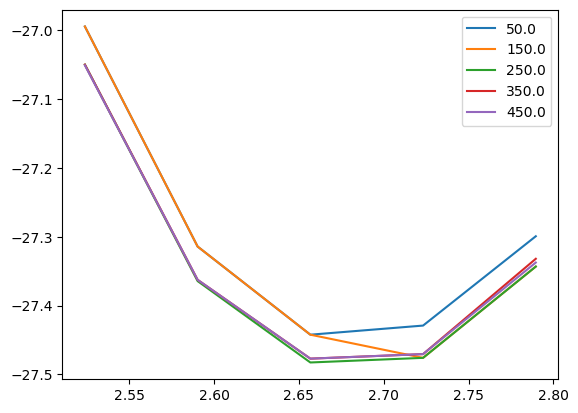

In [80]:
for T, o in zip(Ts, exe.output):
    plt.plot(o.volumes, o.energies, label=T)
plt.legend()

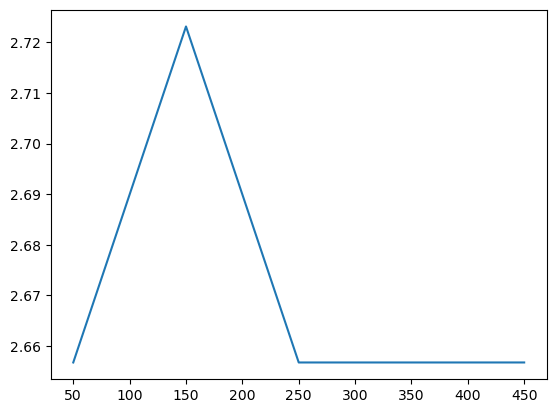

In [84]:
plt.plot(Ts, [o.equilibrium_volume for o in exe.output])